In [55]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("data.csv")
data

,t(h),X,S,P
0,0,1.70,91.45,0.87
1,1,1.65,89.74,1.77
2,2,1.85,87.94,2.03
3,3,2.80,81.84,4.05
4,4,2.65,74.64,8.18
5,5,3.35,65.85,12.80
6,6,3.30,55.23,15.38
7,7,5.05,45.54,21.10
8,8,4.17,37.96,28.06
9,9,3.90,28.66,33.22


In [56]:
def monod(z,umax):
    Yxs = 0.0434
    Yps = 0.5078
    Ypx = Yps/Yxs
    umax=0.1
    Ks = 0.1

    #Assign each variable to a vector z
    X = z[0]
    S = z[1]
    P = z[2]

    #Define the ODE system
    dXdt= umax*S/(Ks+S)*X
    dSdt=-umax*S/(Ks+S)*X/Yxs
    dPdt=umax*S/(Ks+S)*X*Ypx
   
    return [dXdt,dSdt,dPdt]

In [57]:
#Define initial conditions
X0 = data.iloc[0,1]
S0 = data.iloc[0,2]
P0 = data.iloc[0,3]
init = [X0, S0, P0]

In [58]:
#Define the time range of integration
t = data.iloc[:,0]

#Solve the ODE system
x = odeint(monod,init,t)

X = x[:,0]
S = x[:,1]
P = x[:,2]

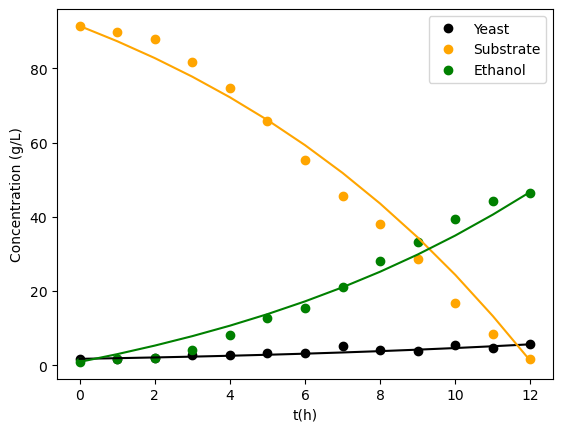

In [59]:
#Graphics

#Experimental data
Xexp =  data.iloc[:,1]
Sexp =  data.iloc[:,2]
Pexp =  data.iloc[:,3]
plt.plot(t, Xexp, 'o', color='black', label = 'Yeast')
plt.plot(t, Sexp, 'o', color='orange', label = 'Substrate')
plt.plot(t, Pexp, 'o', color='green', label = 'Ethanol')

#ODE system model
plt.plot(t, X,'-', color='black')
plt.plot(t, S,'-', color='orange')
plt.plot(t, P,'-', color='green')

plt.xlabel('t(h)')
plt.ylabel('Concentration (g/L)');
plt.legend(loc='best')